<a href="https://colab.research.google.com/github/doggie007/GreenVision/blob/main/Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [4]:
data_dir = '/content/drive/MyDrive/Hackathonsssss/Garbageclassification/'
classes = os.listdir(data_dir)
classes

['metal', 'plastic', 'paper', 'glass', 'trash', 'cardboard']

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: metal (Class No: 2)


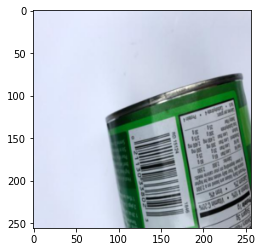

In [7]:
img, label = dataset[1000]
show_sample(img, label)

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


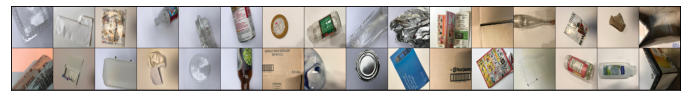

In [13]:
show_batch(train_dl)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(ResNet(), device)

In [21]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


{'val_acc': 0.1371527761220932, 'val_loss': 1.8006808757781982}

In [22]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train_loss: 1.4673, val_loss: 1.2823, val_acc: 0.8108
Epoch 2: train_loss: 1.1897, val_loss: 1.1738, val_acc: 0.9132
Epoch 3: train_loss: 1.0954, val_loss: 1.1407, val_acc: 0.9201
Epoch 4: train_loss: 1.0723, val_loss: 1.1264, val_acc: 0.9340
Epoch 5: train_loss: 1.0620, val_loss: 1.1188, val_acc: 0.9392
Epoch 6: train_loss: 1.0607, val_loss: 1.1078, val_acc: 0.9583
Epoch 7: train_loss: 1.0577, val_loss: 1.1076, val_acc: 0.9514
Epoch 8: train_loss: 1.0560, val_loss: 1.1235, val_acc: 0.9219


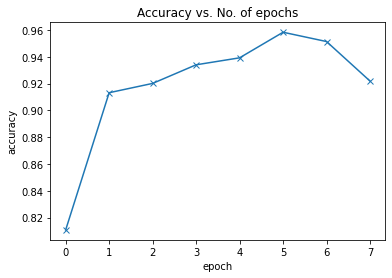

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

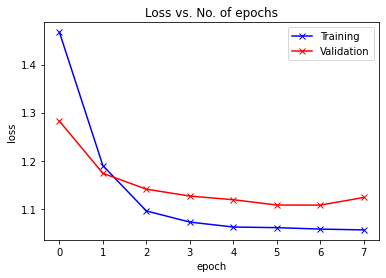

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [25]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

tensor([[0.0031, 0.0034, 0.9994, 0.0036, 0.0037, 0.0038]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
Label: metal , Predicted: metal


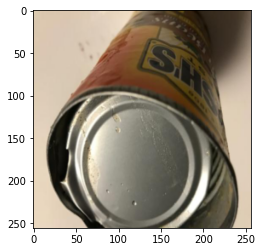

In [26]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

tensor([[[0.9451, 0.9451, 0.9451,  ..., 0.7804, 0.7765, 0.7725],
         [0.9451, 0.9451, 0.9451,  ..., 0.7804, 0.7765, 0.7725],
         [0.9451, 0.9451, 0.9451,  ..., 0.7804, 0.7765, 0.7725],
         ...,
         [0.9255, 0.9255, 0.9216,  ..., 0.7529, 0.7529, 0.7490],
         [0.9255, 0.9255, 0.9216,  ..., 0.7529, 0.7529, 0.7529],
         [0.9255, 0.9255, 0.9216,  ..., 0.7529, 0.7529, 0.7529]],

        [[0.9529, 0.9529, 0.9529,  ..., 0.7882, 0.7843, 0.7804],
         [0.9529, 0.9529, 0.9529,  ..., 0.7882, 0.7843, 0.7804],
         [0.9529, 0.9529, 0.9529,  ..., 0.7882, 0.7843, 0.7804],
         ...,
         [0.9333, 0.9333, 0.9294,  ..., 0.7490, 0.7490, 0.7451],
         [0.9333, 0.9333, 0.9294,  ..., 0.7490, 0.7490, 0.7490],
         [0.9333, 0.9333, 0.9294,  ..., 0.7490, 0.7490, 0.7490]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8392, 0.8353, 0.8314],
         [1.0000, 1.0000, 1.0000,  ..., 0.8392, 0.8353, 0.8314],
         [1.0000, 1.0000, 1.0000,  ..., 0.8392, 0.8353, 0.

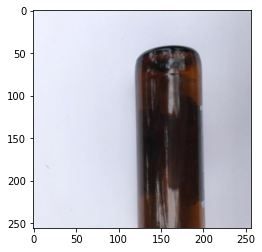

In [27]:
img, label = test_ds[23]
print(img)
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

tensor([[0.0014, 0.0038, 0.0033, 0.9998, 0.0053, 0.0012]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[2.5193e-03, 1.1714e-02, 3.9409e-04, 7.4699e-04, 9.9992e-01, 7.8445e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.9994, 0.0059, 0.0031, 0.0028, 0.0055, 0.0045]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[1.6116e-03, 2.3426e-03, 9.9985e-01, 1.7280e-03, 1.9854e-03, 9.7572e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.0047, 0.0210, 0.0274, 0.0011, 0.9931, 0.0023]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[2.1431e-03, 6.1811e-03, 2.8814e-03, 9.9971e-01, 7.3650e-04, 1.4611e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.0049, 0.0032, 0.0058, 0.0021, 0.9998, 0.0012]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[0.8425, 0.0027, 0.0034, 0.7607, 0.0028, 0.0021]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[0.0118, 0.8368, 0.0479, 0.0179, 0.4109,

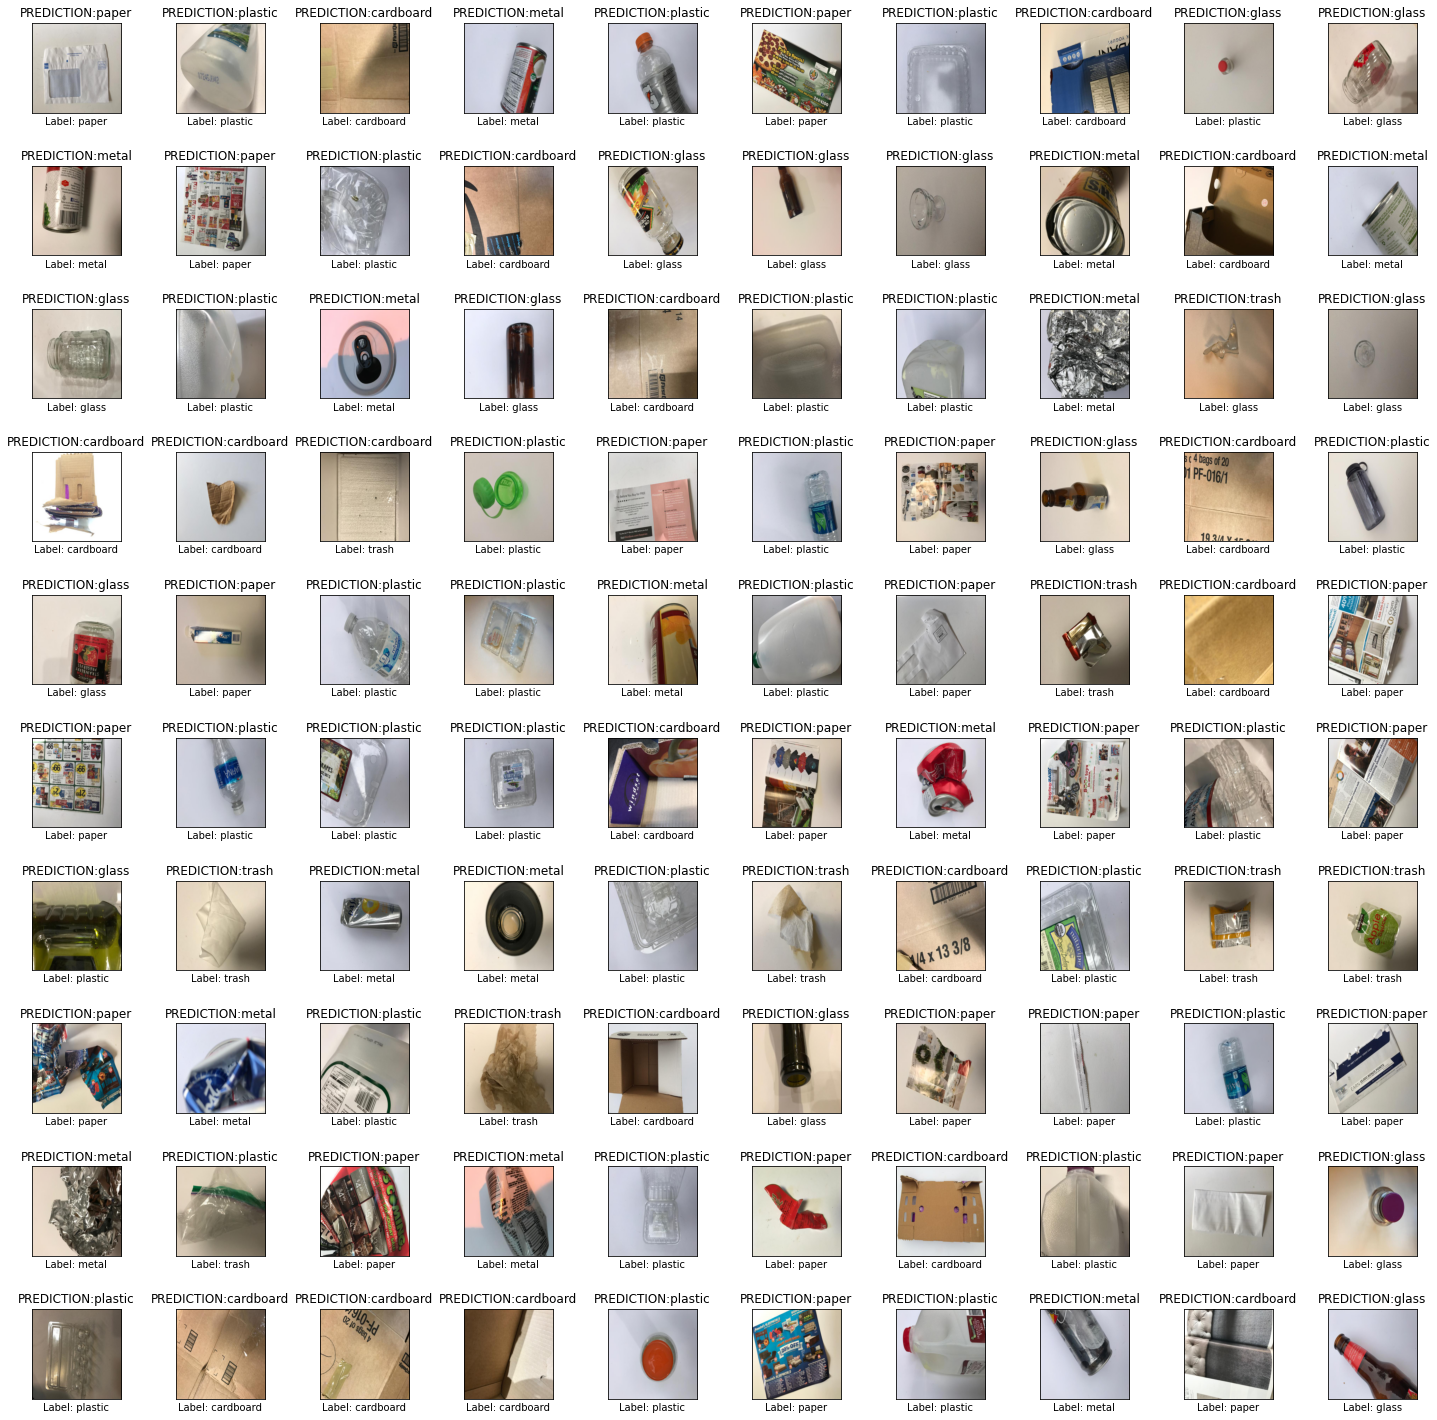

In [28]:
fig, axes = plt.subplots(nrows=10,ncols=10,figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img, label = test_ds[i]
    ax.imshow(img.permute(1,2,0)) 
    ax.set_title(f"PREDICTION:{predict_image(img,model)}")
    ax.set_xlabel(f"Label: {dataset.classes[label]}")
plt.tight_layout()
plt.show()